In [1]:
from cell_segmentation.datasets.pannuke import PanNukeDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import albumentations as A
from matplotlib import pyplot as plt
import numpy as np
import random

random.seed(42)
np.random.seed(42)

In [6]:
transformations = [
    A.RandomRotate90(p=0.75),
    A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.75)
]
transforms= A.ReplayCompose(transformations)

In [22]:
index = 0
dataset = PanNukeDataset(
    dataset_path="/projects/datashare/tio/histopathology/public-datasets/PanNuke/digitalhistologyhub", 
    folds=[0]
)
image, mask, tissue_type, name = dataset.__getitem__(index)
mask_map_np = np.stack([
    mask["instance_map"].detach().cpu().numpy(), 
    mask["nuclei_type_map"].detach().cpu().numpy()
], axis=-1)
image_np = image.permute(1, 2, 0).detach().cpu().numpy()
orig_dist_map = PanNukeDataset.gen_distance_prob_maps(mask["instance_map"].detach().cpu().numpy())
orig_stardist_map = PanNukeDataset.gen_stardist_maps(mask["instance_map"].detach().cpu().numpy()).transpose(1,2,0)

In [35]:
name

'0_0.png'

In [29]:
# loading, transforming, stardist
data_usual = transforms(image=image_np, mask=mask_map_np)
data_usual_mask = data_usual["mask"]
inst_map = data_usual_mask[:, :, 0].copy()
dist_map = PanNukeDataset.gen_distance_prob_maps(inst_map)
star_dist_map = PanNukeDataset.gen_stardist_maps(inst_map).transpose(1,2,0)

# loading, stardist, transforming
mask_map_all_np = np.concatenate([
            mask_map_np, 
            orig_dist_map[:,:, None],
            orig_stardist_map
        ], 
    axis=-1
)

data_new = A.ReplayCompose.replay(data_usual["replay"], image=image_np, mask=mask_map_all_np)

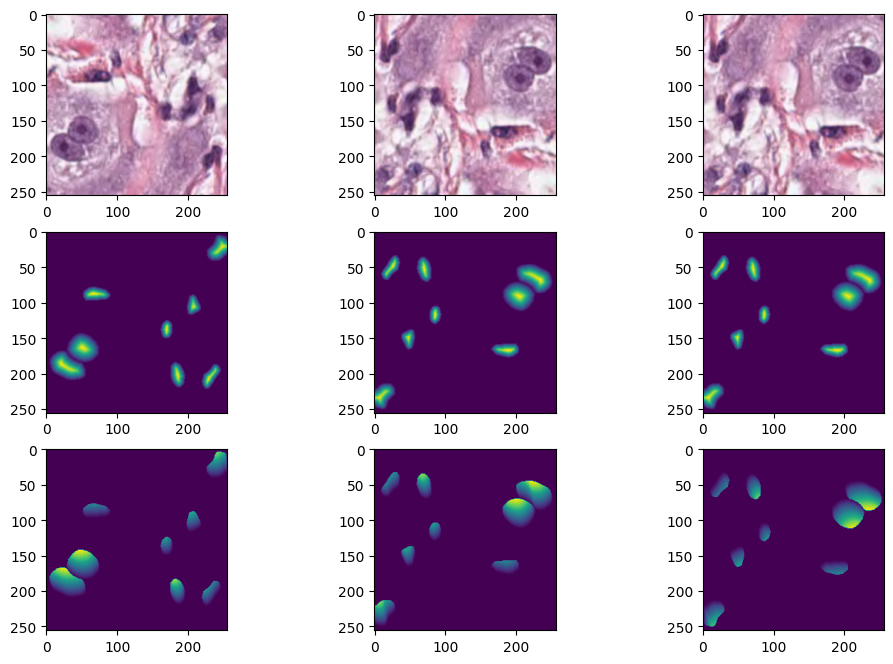

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes[0,0].imshow(image_np)
axes[0,1].imshow(data_usual["image"])
axes[0,2].imshow(data_new["image"])
axes[1,0].imshow(orig_dist_map)
axes[1,1].imshow(dist_map)
axes[1,2].imshow(data_new["mask"][:,:,2])
axes[2,0].imshow(orig_stardist_map[:,:,7])
axes[2,1].imshow(star_dist_map[:,:,7])
axes[2,2].imshow(data_new["mask"][:,:,9])

In [32]:
import sys
sys.path.append("/homes/fhoerst/histo-projects/CellSeg/cellseg_models.pytorch/cellseg_models_pytorch")
from cellseg_models_pytorch.transforms.functional import gen_stardist_maps, gen_dist_maps


In [47]:
from numba import njit

@njit
def gen_stardist_maps_local(inst_map: np.ndarray) -> np.ndarray:
    n_rays = 32
    # inst_map = fix_duplicates(inst_map)
    dist = np.empty(inst_map.shape + (n_rays,), np.float32)

    st_rays = np.float32((2 * np.pi) / n_rays)
    for i in range(inst_map.shape[0]):
        for j in range(inst_map.shape[1]):
            value = inst_map[i, j]
            if value == 0:
                dist[i, j] = 0
            else:
                for k in range(n_rays):
                    phi = np.float32(k * st_rays)
                    dy = np.cos(phi)
                    dx = np.sin(phi)
                    x, y = np.float32(0), np.float32(0)
                    while True:
                        x += dx
                        y += dy
                        ii = int(round(i + x))
                        jj = int(round(j + y))
                        if (
                            ii < 0
                            or ii >= inst_map.shape[0]
                            or jj < 0
                            or jj >= inst_map.shape[1]
                            or value != inst_map[ii, jj]
                        ):
                            # small correction as we overshoot the boundary
                            t_corr = 1 - 0.5 / max(np.abs(dx), np.abs(dy))
                            x -= t_corr * dx
                            y -= t_corr * dy
                            dst = np.sqrt(x**2 + y**2)
                            dist[i, j, k] = dst
                            break

    return dist.transpose(2, 0, 1)

In [48]:
%timeit -n 3 -r 3 d = gen_stardist_maps_local(inst_map)

The slowest run took 11.67 times longer than the fastest. This could mean that an intermediate result is being cached.
66 ms ± 72.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [41]:
%timeit -n 3 -r 3 d = gen_stardist_maps(inst_map, 32)

18.4 ms ± 2.97 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [40]:
%timeit d = PanNukeDataset.gen_stardist_maps(inst_map)

KeyboardInterrupt: 

In [95]:
print(np.array_equal(data_usual["mask"][:,:,0], data_new["mask"][:,:,0]))
print(np.array_equal(data_usual["mask"][:,:,1], data_new["mask"][:,:,1]))
print(np.array_equal(data_usual["mask"][:,:,2], data_new["mask"][:,:,2]))
print(np.array_equal(data_usual["mask"][:,:,3], data_new["mask"][:,:,3]))

True
True
False
False
